# Problem Description:
The goal of this project is to predict the best next move in a game of Tic-Tac-Toe using machine learning techniques. The Tic-Tac-Toe game is a classic two-player game played on a 3x3 grid where players alternately place their marks (X or O) on empty cells. The objective is to align three of their marks horizontally, vertically, or diagonally. By leveraging historical game data, this project aims to train a model that can predict the optimal next move for a given board state, considering both offense and defense strategies.

# Data Overview:
The dataset consists of Tic-Tac-Toe game states, with each row representing a unique game configuration (board state) and the corresponding outcome or recommendation for the next move.
#### Each cell on the board is encoded with either:
'x': Player X's mark

'o': Player O's mark

'b': An empty cell (indicating a potential next move)

Each game configuration is paired with the recommended best next move for the player whose turn it is, aiming to either block the opponent's winning move or make a winning move themselves.

# Features:
The dataset contains the following 9 features representing the 3x3 grid of the Tic-Tac-Toe board:

TL : top-left

TM : top-middle

TR : top-right

ML : middle-left

MM : middle-middle

MR : middle-right

BL : bottom-left

BM: bottom-middle

BR : bottom-right

#### Each of these features can have values:

'X' (player X's mark),


'O' (player O's mark),

'B' (empty cell).

# Target Variable:
Best Next Move: The target variable represents the optimal next move for the player. This is a categorical variable that indicates which position on the board (among the empty cells) is the best move based on the current state of the game.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Read Dataset

In [2]:
data=pd.read_csv('tic-tac-toe.csv')
data

,TL,TM,TR,ML,MM,MR,BL,BM,BR,class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,False
954,o,x,o,x,x,o,x,o,x,False
955,o,x,o,x,o,x,x,o,x,False
956,o,x,o,o,x,x,x,o,x,False


# Exploratory Data Analysis (EDA)

In [3]:
#number of rows and columns
print('We have',data.shape[0],'rows with',data.shape[1],'columns')

We have 958 rows with 10 columns


In [4]:
#checking null values
data.isna().sum()

TL       0
TM       0
TR       0
ML       0
MM       0
MR       0
BL       0
BM       0
BR       0
class    0
dtype: int64

In [5]:
data.describe()

,TL,TM,TR,ML,MM,MR,BL,BM,BR,class
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,True
freq,418,378,418,378,458,378,418,378,418,626


### Plot each feature vs. target

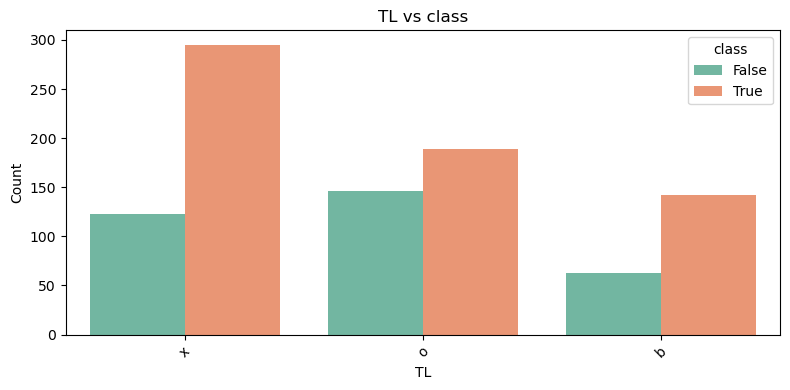

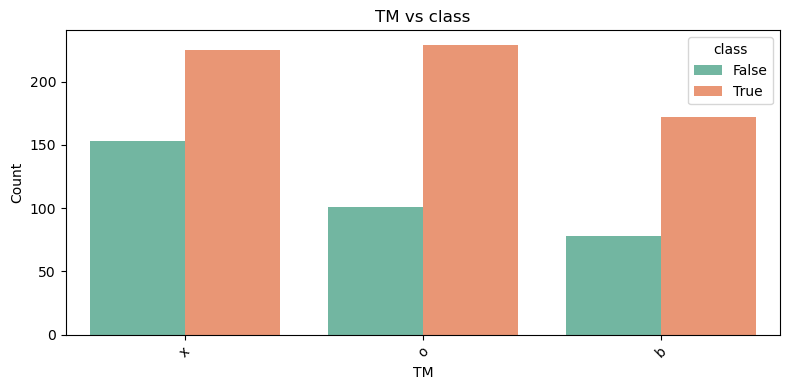

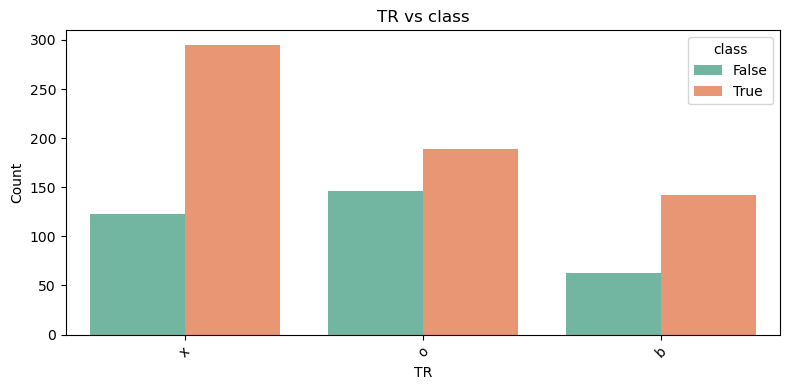

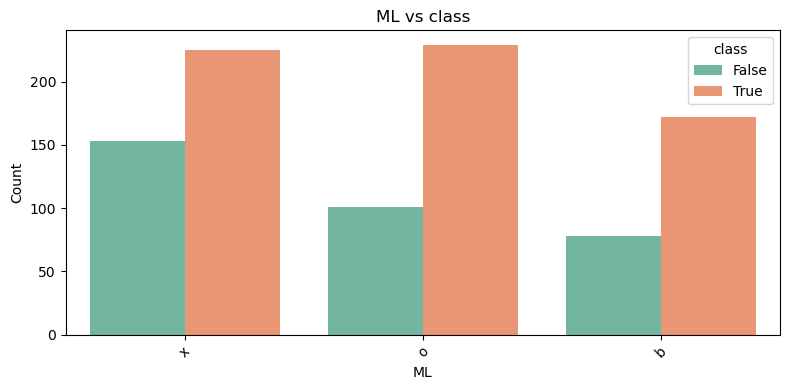

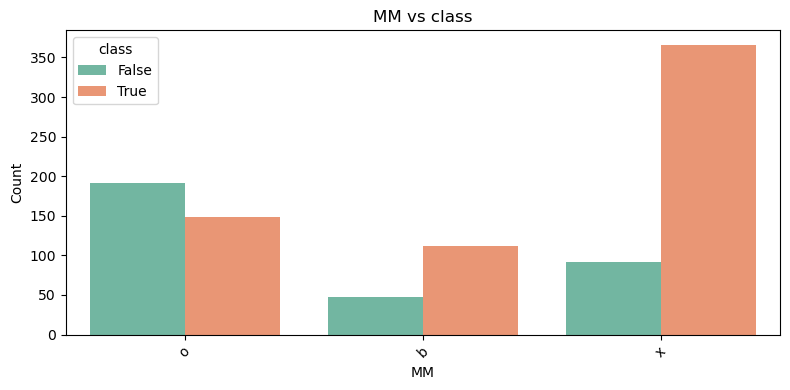

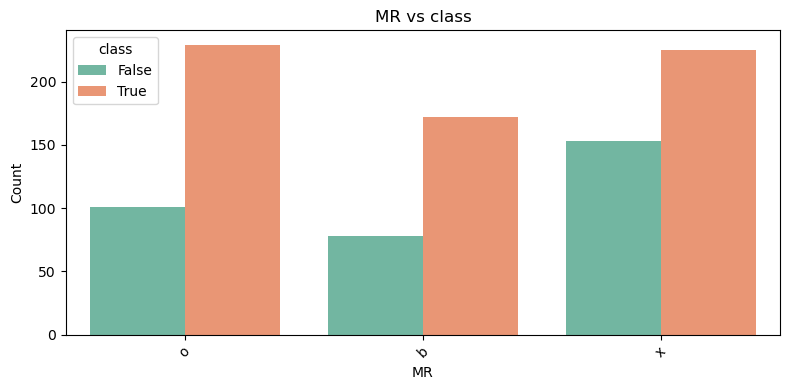

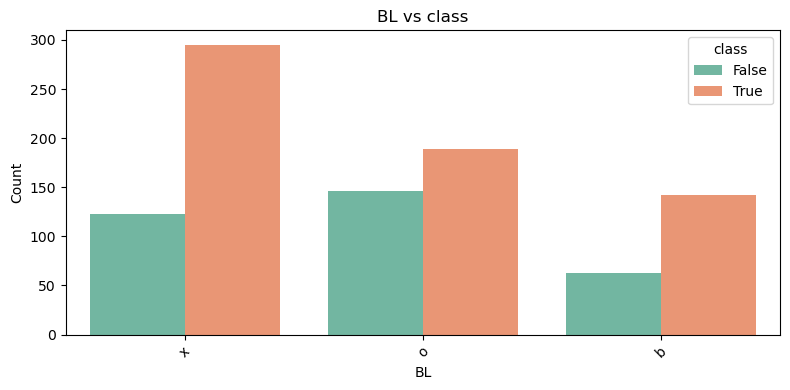

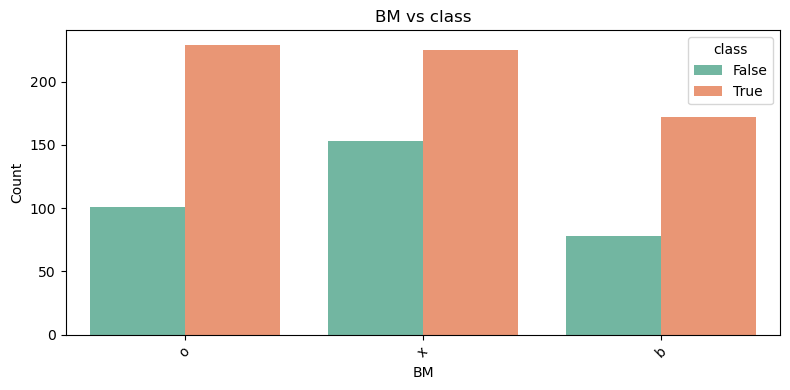

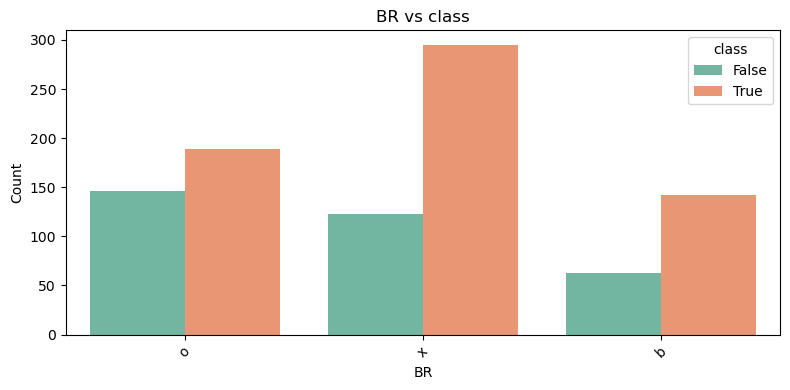

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the target variable 
target_col = 'class' 

# Loop through each feature (column) in the dataset
for col in data.columns:
    if col != target_col:     # Skip the target column itself
        plt.figure(figsize=(8, 4))
        
        # Check if the column is categorical
        if data[col].nunique() < 10:  # Assuming less than 10 unique values means it's categorical
            sns.countplot(x=col, hue=target_col, data=data, palette="Set2")
        else:
            # If the feature is continuous or has many unique values, use a boxplot
            sns.boxplot(x=target_col, y=col, data=data, palette="Set2")
        
        # Customize the plot
        plt.title(f'{col} vs {target_col}')
        plt.xlabel(col)
        plt.ylabel('Count' if data[col].nunique() < 10 else col)
        plt.xticks(rotation=45)           #rotates x-axis label
        
        # Show the plot
        plt.tight_layout()
        plt.show()


### Distribution of each board position

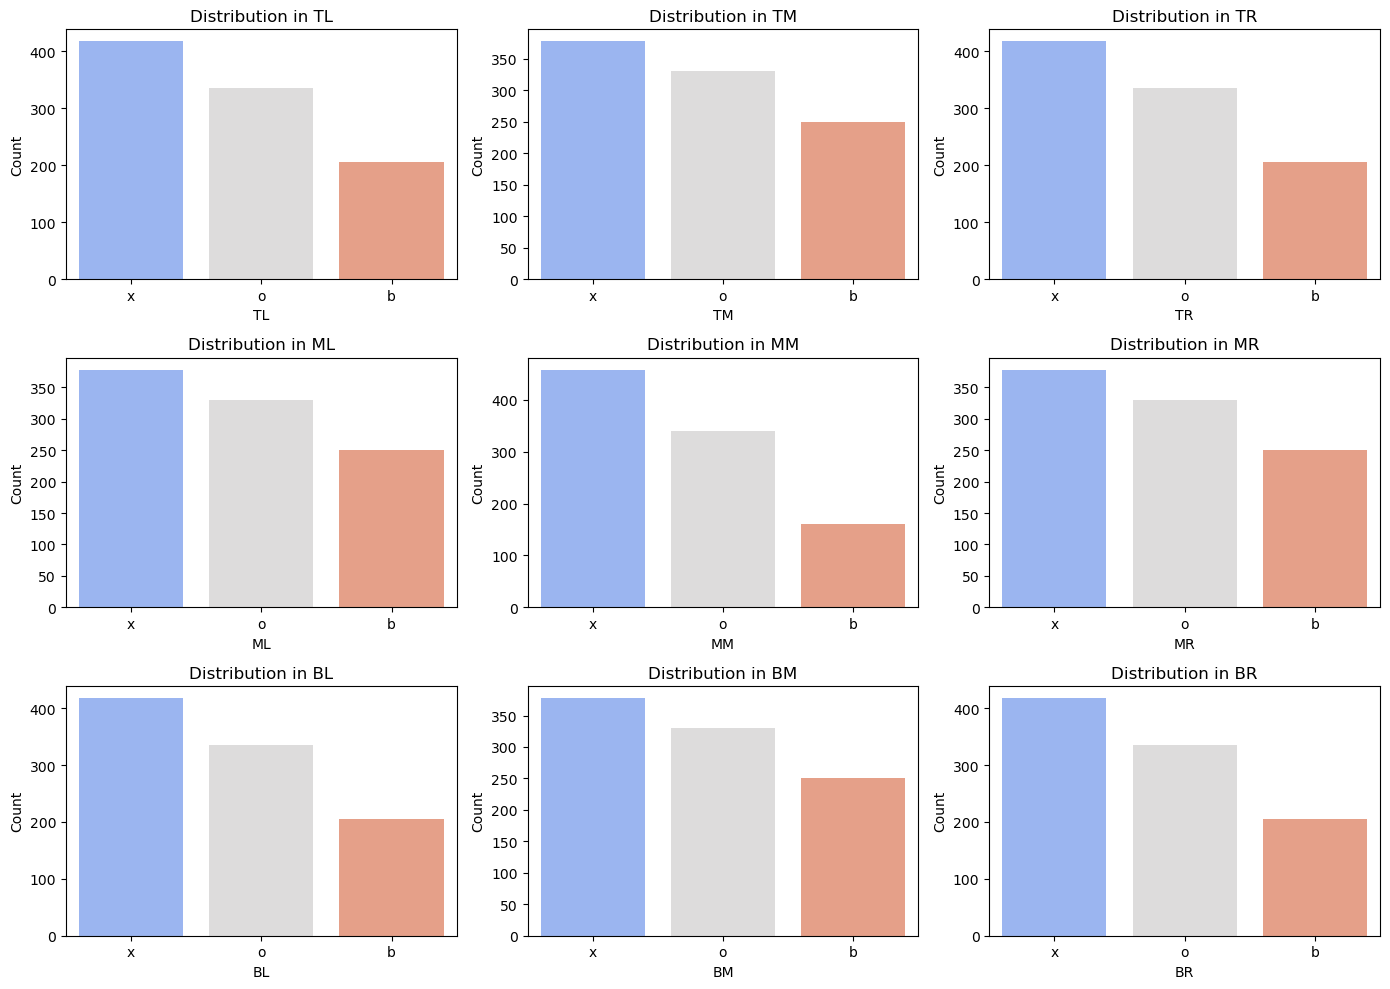

In [7]:
# Plot distribution for each board position
plt.figure(figsize=(14, 10))
for i, column in enumerate(data.columns[:-1], 1):  # Exclude the target column
    plt.subplot(3, 3, i)                                                        #i controls which cell is used for the current column
    sns.countplot(x=column, data=data, palette='coolwarm', order=['x','o','b'])  # Adjust order if needed
    plt.title(f'Distribution in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Encoding

In [8]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TL      958 non-null    object
 1   TM      958 non-null    object
 2   TR      958 non-null    object
 3   ML      958 non-null    object
 4   MM      958 non-null    object
 5   MR      958 non-null    object
 6   BL      958 non-null    object
 7   BM      958 non-null    object
 8   BR      958 non-null    object
 9   class   958 non-null    bool  
dtypes: bool(1), object(9)
memory usage: 68.4+ KB


In [9]:
# Check unique values in the dataset before proceeding
for column in data.columns[:]: 
    print(f"Unique values in {column}: {data[column].unique()}")

Unique values in TL: ['x' 'o' 'b']
Unique values in TM: ['x' 'o' 'b']
Unique values in TR: ['x' 'o' 'b']
Unique values in ML: ['x' 'o' 'b']
Unique values in MM: ['o' 'b' 'x']
Unique values in MR: ['o' 'b' 'x']
Unique values in BL: ['x' 'o' 'b']
Unique values in BM: ['o' 'x' 'b']
Unique values in BR: ['o' 'x' 'b']
Unique values in class: [ True False]


In [10]:
#Define a mapping dictionary for board position
mapping_board={'x':1, 'o':-1, 'b':0}      #empty spaces are represented by 'b'

# Apply the map function to each column that represents the board state
for column in data.columns[:-1]:                 #Excludingthe last column is the target (best move)
    data[column] = data[column].map(mapping_board)

In [11]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['class'] =le.fit_transform(data['class'])    #target column

#Display the first few rows after encoding
print(data.head())

   TL  TM  TR  ML  MM  MR  BL  BM  BR  class
0   1   1   1   1  -1  -1   1  -1  -1      1
1   1   1   1   1  -1  -1  -1   1  -1      1
2   1   1   1   1  -1  -1  -1  -1   1      1
3   1   1   1   1  -1  -1  -1   0   0      1
4   1   1   1   1  -1  -1   0  -1   0      1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TL      958 non-null    int64
 1   TM      958 non-null    int64
 2   TR      958 non-null    int64
 3   ML      958 non-null    int64
 4   MM      958 non-null    int64
 5   MR      958 non-null    int64
 6   BL      958 non-null    int64
 7   BM      958 non-null    int64
 8   BR      958 non-null    int64
 9   class   958 non-null    int64
dtypes: int64(10)
memory usage: 75.0 KB


In [13]:
data.isna().sum()

TL       0
TM       0
TR       0
ML       0
MM       0
MR       0
BL       0
BM       0
BR       0
class    0
dtype: int64

## Correlation Heatmap

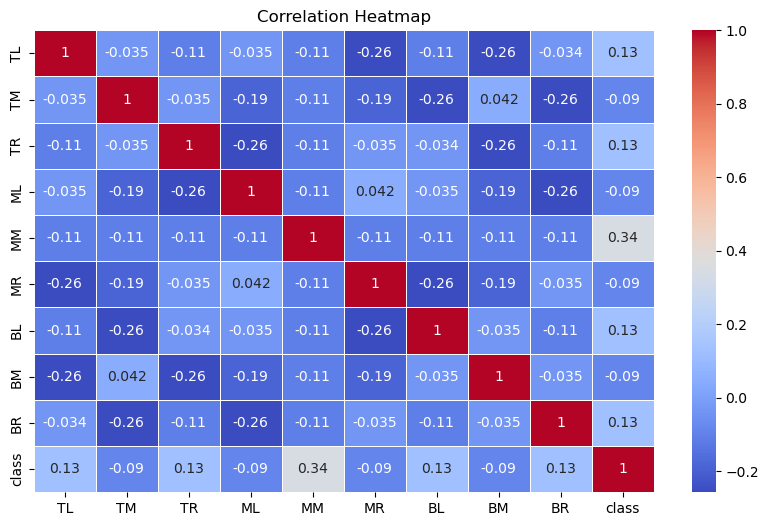

In [14]:
#Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

#correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Dataset Balancing

In [15]:
# count the target variable
data['class'].value_counts()

class
1    626
0    332
Name: count, dtype: int64

<Axes: ylabel='count'>

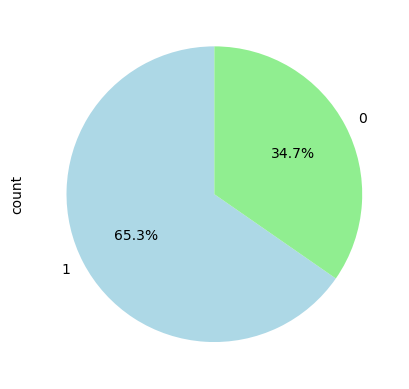

In [16]:
data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])

In [17]:
# Under sampling

In [18]:
#pip install --user imblearn

In [19]:
#pip install imblearn-learn

In [20]:
#using under sampling (majority class of data points is order to balance the dataset)
import imblearn             #imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

rus=RandomUnderSampler(sampling_strategy=1)               #sampling_strategy=1 :simple balanced dataset where both classes are equal in size.

x_res,y_res=rus.fit_resample(data.drop('class',axis=1),data['class'])
data=pd.concat([pd.DataFrame(y_res),pd.DataFrame(x_res)],axis=1)

<Axes: ylabel='count'>

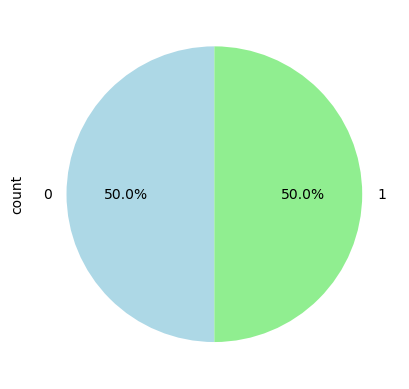

In [21]:
data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])

# check for Outliers

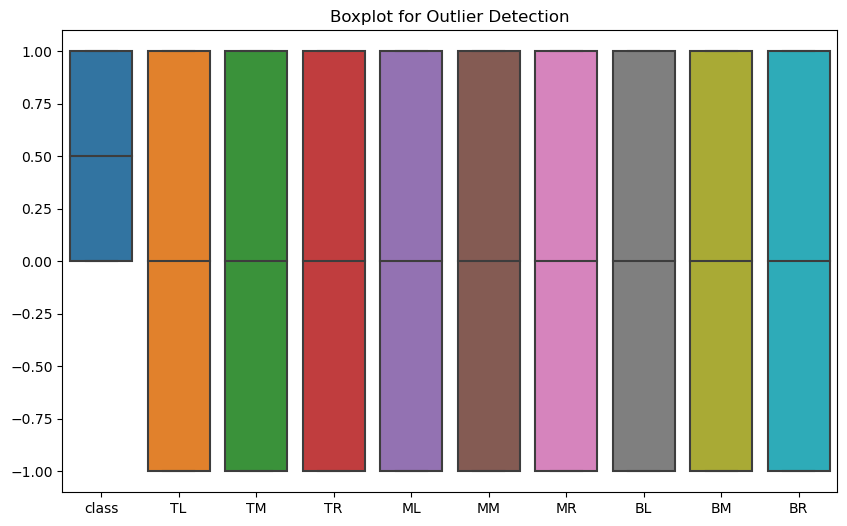

In [22]:
#Boxplot for checking outliers
plt.figure(figsize=(10,6))
sns.boxplot(data)
plt.title('Boxplot for Outlier Detection')
plt.show()

# Train - Test Split 

In [23]:
from sklearn.model_selection import train_test_split

#seperate features(x) and target(y)
x=data.drop(['class'],axis=1)
y=data['class']

#split data into training and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

# print("Test data\n",y_test.value_counts())
# print("Train data\n",y_train.value_counts())

# Model Creation and Training

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV

# Hyperparameter Tuning

In [25]:
model_params = {
    'svm':{'model':SVC(gamma='auto'), 'params':{'C':[1,10,20],'kernel':['rbf','linear']}},
    "random_forest": {"model": RandomForestClassifier(), "params": {"n_estimators": [1, 5, 10]}},
    "logistic_regression": {"model": LogisticRegression(),'params':{'C':[1,5,10]}},
    "adaboost": {"model": AdaBoostClassifier(estimator=DecisionTreeClassifier()), "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0], "random_state":[10,50,100]}},
    "gradient_boosting": {"model": GradientBoostingClassifier(), "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0], "max_depth": [3, 4, 5], "random_state":[10,50,100]}},
    "xgboost": {"model": XGBClassifier(), "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0], "max_depth": [3, 4, 5]}},
    "decision_tree": {"model": DecisionTreeClassifier(), "params": {"max_depth": [3, 4, 5]}},
    "knn":{"model":KNeighborsClassifier(),"params":{"n_neighbors":[5,10]}}
}

In [26]:
scores=[]
models=['svm',"random_forest","logistic_regression",'adaboost','gradient_boosting','xgboost','decision_tree',"knn"]
for model_name in models:
    mp=model_params[model_name]
    gds=GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=True)
    gds.fit(x_train,y_train)
    scores.append({"model":model_name,"best_score":gds.best_score_,"best_params":gds.best_params_})

In [27]:
scores

[{'model': 'svm',
  'best_score': 0.985959595959596,
  'best_params': {'C': 10, 'kernel': 'rbf'}},
 {'model': 'random_forest',
  'best_score': 0.9237373737373737,
  'best_params': {'n_estimators': 10}},
 {'model': 'logistic_regression',
  'best_score': 0.9779191919191919,
  'best_params': {'C': 1}},
 {'model': 'adaboost',
  'best_score': 0.9195959595959596,
  'best_params': {'learning_rate': 0.01,
   'n_estimators': 50,
   'random_state': 100}},
 {'model': 'gradient_boosting',
  'best_score': 0.993979797979798,
  'best_params': {'learning_rate': 1.0,
   'max_depth': 3,
   'n_estimators': 200,
   'random_state': 10}},
 {'model': 'xgboost',
  'best_score': 0.981979797979798,
  'best_params': {'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 50}},
 {'model': 'decision_tree',
  'best_score': 0.8410707070707071,
  'best_params': {'max_depth': 5}},
 {'model': 'knn',
  'best_score': 0.9558383838383838,
  'best_params': {'n_neighbors': 5}}]

In [28]:
df=pd.DataFrame(scores)
df

,model,best_score,best_params
0,svm,0.985960,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.923737,{'n_estimators': 10}
2,logistic_regression,0.977919,{'C': 1}
3,adaboost,0.919596,"{'learning_rate': 0.01, 'n_estimators': 50, 'r..."
4,gradient_boosting,0.993980,"{'learning_rate': 1.0, 'max_depth': 3, 'n_esti..."
5,xgboost,0.981980,"{'learning_rate': 1.0, 'max_depth': 4, 'n_esti..."
6,decision_tree,0.841071,{'max_depth': 5}
7,knn,0.955838,{'n_neighbors': 5}


In [29]:
# Best model selection
best_model = gds.best_estimator_
print(f"model: {model_name} , Best Score: {gds.best_score_} , Best Parameters: {gds.best_params_}")

model: knn , Best Score: 0.9558383838383838 , Best Parameters: {'n_neighbors': 5}


# Model Creation and Prediction

In [30]:
#Train the model
best_model.fit(x_train,y_train)

#Predict on test data
y_pred = best_model.predict(x_test)

# Confusion matrix and Classification Report

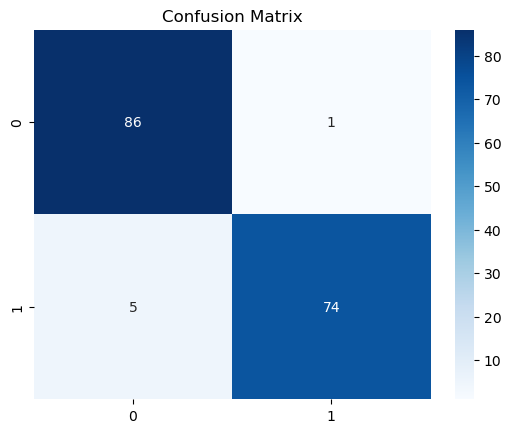

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        87
           1       0.99      0.94      0.96        79

    accuracy                           0.96       166
   macro avg       0.97      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



In [31]:
#Confusion matrix
conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')         #fmt='g' formats the annotations as integers.
plt.title('Confusion Matrix')
plt.show()

#Classification report
print(classification_report(y_test, y_pred))

# Save the model using joblib

In [32]:
import joblib             # from sklearn.externals import joblib

# save the best model
joblib.dump(best_model, 'tic_tac_toe_best_model.pkl')

['tic_tac_toe_best_model.pkl']

# Start our game ---(User input)

In [36]:
# Load the saved model
model = joblib.load('tic_tac_toe_best_model.pkl')



# Function to display the board
def display_board(board):
    symbols = {1: 'X', -1: 'O', 0: ' '}
    for row in range(3):
        print(' | '.join([symbols[cell] for cell in board[row*3:(row+1)*3]]))
        if row < 2:
            print('--+---+--')

# Function to get input from the user for the current board state
def get_user_input():
    print("Enter the current Tic-Tac-Toe board state.")
    print("Use 1 for 'X', -1 for 'O', and 0 for empty spaces.")
    
    board = []
    for i in range(9):
        while True:
            try:
                cell_value = int(input(f"Enter value for cell {i} (0, 1, -1): "))
                if cell_value in [1, -1, 0]:
                    board.append(cell_value)
                    break
                else:
                    print("Please enter 0, 1, or -1.")
            except ValueError:
                print("Invalid input. Please enter an integer.")
    
    return np.array(board)


# Predict the next move using model
def predict_next_move(board_state, best_model):
    board_state = board_state.reshape(1, -1)  # Reshape for predict the best next move
    predicted_move = model.predict(board_state)[0]
    return predicted_move

# Example flow for prediction
def play_tic_tac_toe_with_model(best_model):
    # Get the board from the user
    board = get_user_input()
    
    # Display the current board
    print("\nCurrent board:")
    display_board(board)
    
    # Predict the next move
    predicted_move = predict_next_move(board, best_model)
    
    print(f"\nThe model predicts the next best move is at position: {predicted_move}")
    
     # Update board with the predicted move (for display)
    board[predicted_move] = 1  # Assuming it's player "X"'s turn
    print("\nUpdated board with the model's move:")
    display_board(board)

# Example: Using the trained model
# Assuming the model has already been trained as in the previous code
play_tic_tac_toe_with_model(best_model)


Enter the current Tic-Tac-Toe board state.
Use 1 for 'X', -1 for 'O', and 0 for empty spaces.
Enter value for cell 0 (0, 1, -1): 1
Enter value for cell 1 (0, 1, -1): 0
Enter value for cell 2 (0, 1, -1): 1
Enter value for cell 3 (0, 1, -1): -1
Enter value for cell 4 (0, 1, -1): 1
Enter value for cell 5 (0, 1, -1): -1
Enter value for cell 6 (0, 1, -1): -1
Enter value for cell 7 (0, 1, -1): 0
Enter value for cell 8 (0, 1, -1): 0

Current board:
X |   | X
--+---+--
O | X | O
--+---+--
O |   |  

The model predicts the next best move is at position: 1

Updated board with the model's move:
X | X | X
--+---+--
O | X | O
--+---+--
O |   |  


# Project ends